In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
import pandas as pd
import os

logging.set_verbosity(logging.ERROR)

Begin by looking at the structure of the csv that contains the data:

             237
date            
2021-01-01   815
2021-01-02  1280
2021-01-03   877
2021-01-04  2291
2021-01-05  2432
...          ...
2023-12-27  3044
2023-12-28  3323
2023-12-29  3129
2023-12-30  2659
2023-12-31  2343

[1095 rows x 1 columns]
150
151
152
[   0    1    2 ... 1092 1093 1094]
[ 815 1280  877 ... 3129 2659 2343]


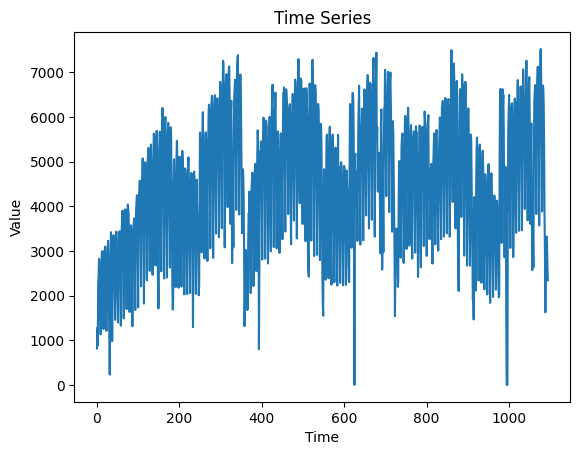

In [2]:
# load the CSV dataset
plot_df = pd.read_csv("merged_taxi.csv")
plot_df.set_index('date', inplace = True)

region = '237'
plot_df = pd.DataFrame(plot_df[region])
plot_df.head()
print(plot_df)
# prompt: seperate 2 arrays of date and plot_df['50']

print(plot_df.index.get_loc('2021-05-31'))
print(plot_df.index.get_loc('2021-06-01'))
print(plot_df.index.get_loc('2021-06-02'))

date_array = plot_df.index.to_numpy()
time = np.arange(len(date_array))
series = plot_df[region].to_numpy()

print(time)
print(series)


# prompt: plot time and series

import matplotlib.pyplot as plt

plt.title('Time Series')
plt.ylabel('Value')
plt.xlabel('Time')

plt.plot(time, series)
plt.show()

In [3]:

def plot_series(time, series, format="-", start=0, end=None, labels=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int or tuple of arrays) - contains the measurements for each time step
      format - line style when plotting the graph
      labels (list of str) - tags for the lines
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:
        if labels is None:
            labels = [None] * len(series)
        for series_num, label in zip(series, labels):
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format, label=label)
    else:
        # Plot the time series data
        plt.plot(time[start:end], series[start:end], format, label=labels)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Display the legend
    if labels is not None:
        plt.legend()

    # Draw the graph on screen
    plt.show()

<Figure size 1000x600 with 0 Axes>

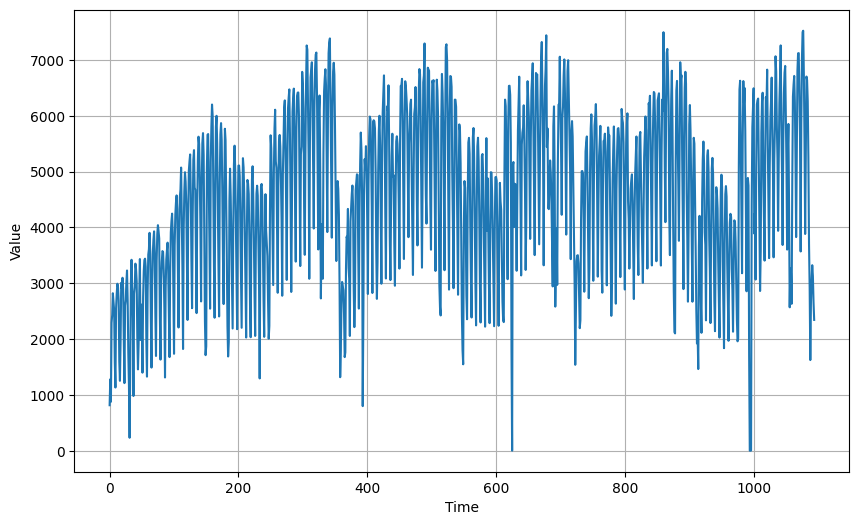

In [4]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    times, temperatures = time , series
    TIME = np.array(times)
    SERIES = np.array(series)
    SPLIT_TIME = 1002
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

**Expected Output:**
<div>
<img src="images/temp-series.png" width="500"/>
</div>

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you:

In [5]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [6]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define your layer architecture. Just as in last week's assignment you will do the layer definition and compilation in two separate steps. Begin by completing the `create_uncompiled_model` function below.


In [31]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([ 
        # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        # tf.keras.layers.LSTM(64, return_sequences=True),
        # tf.keras.layers.LSTM(64),
        # # tf.keras.layers.Lambda(lambda x: x * 100.0),
        # tf.keras.layers.Dense(500, activation="relu"),
        
        tf.keras.layers.Dense(500, activation="relu", input_shape=[G.WINDOW_SIZE]),
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(1)
        
        
    ]) 
    
    ### END CODE HERE

    return model

You can test your model with the code below. If you get an error, it's likely that your model is returning a sequence. You can indeed use an LSTM with `return_sequences=True` but you have to feed it into another layer that generates a single prediction. You can review the lectures or the previous ungraded labs to see how that is done.

In [28]:
# Test your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):
    
    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)
    
# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate - (Optional Exercise)

As you saw in the lectures, you can leverage Tensorflow's callbacks to dynamically vary the learning rate before doing the actual training. This can be helpful in finding what value works best with your model. Note that this is only one way of finding the best learning rate. There are other techniques for hyperparameter optimization but it is outside the scope of this course.

For the optimizers you can try out:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [29]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [30]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100


ValueError: Shapes used to initialize variables must be fully-defined (no `None` dimensions). Received: shape=(None, 500) for variable path='sequential_10/dense_50/kernel'

(1e-08, 0.001, 0.0, 1000.0)

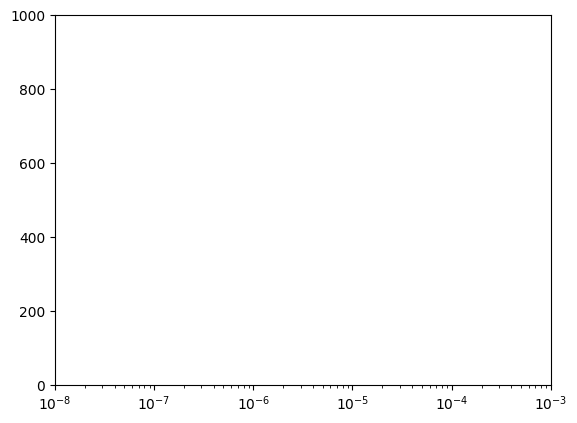

In [25]:

plt.semilogx(lr_history.history['learning_rate'], lr_history.history["loss"])
plt.axis([1e-8, 1e-03, 0, 1000])



## Compiling the model
Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hints:

- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: loss: nan - mae: nan it is very likely that your network is suffering from exploding gradients. This is a common problem if you used SGD as optimizer and set a learning rate that is too high. If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.

In [20]:
def create_model():

    
    model = create_uncompiled_model()

    ### START CODE HERE
    
    learning_rate =1e-7

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
                  metrics=["mae"])  
    

    ### END CODE HERE

    return model

In [21]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=100)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4603.6460 - mae: 4604.1455
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4629.2285 - mae: 4629.7280
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4557.3911 - mae: 4557.8906
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4591.9487 - mae: 4592.4482
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4519.1011 - mae: 4519.6011
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4596.6045 - mae: 4597.1045
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4546.1636 - mae: 4546.6626
Epoch 8/100
 1/30 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 4647.5938 - mae: 4648.0938

KeyboardInterrupt: 

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [196]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts

In the previous week you saw a faster approach compared to using a for loop to compute the forecasts for every point in the sequence. Remember that this faster approach uses batches of data. 

The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [197]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Now compute the actual forecast:

**Note:** Don't modify the cell below. 

The grader uses the same slicing to get the forecast so if you change the cell below you risk having issues when submitting your model for grading.

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x600 with 0 Axes>

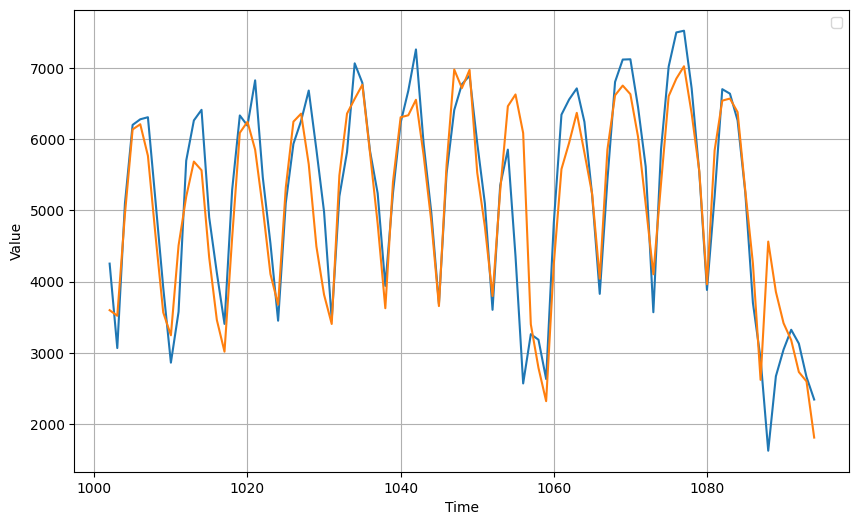

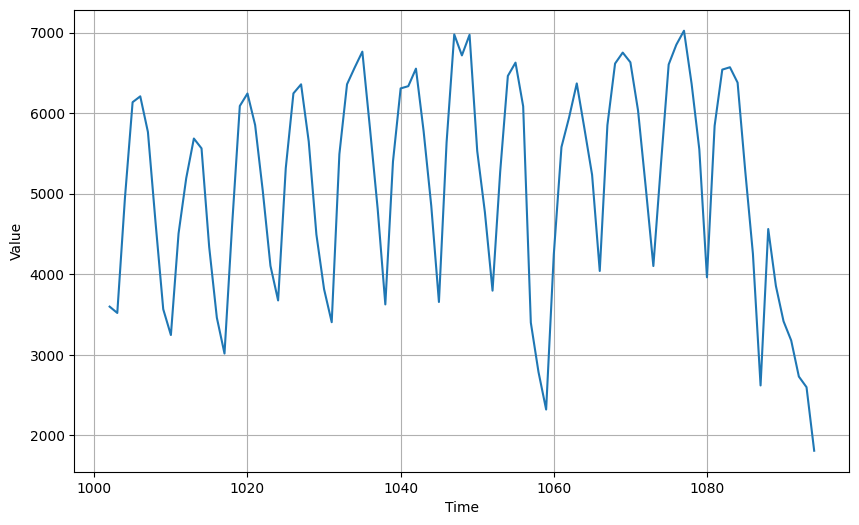

In [198]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
# rnn_forecast = rnn_forecast

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, (series_valid,rnn_forecast))
plot_series(time_valid, rnn_forecast)

In [199]:
mse = tf.keras.losses.MeanSquaredError()(series_valid, rnn_forecast).numpy()
mae = tf.keras.losses.MeanAbsoluteError()(series_valid, rnn_forecast).numpy()
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


RMSE: 710.7205200195312
MAE: 468.9518127441406


[5290 6333 6190 6826 5464 4534 3450]
[4618.809  6089.499  6244.192  5852.6196 5032.811  4104.7866 3674.86  ]


<Figure size 1000x600 with 0 Axes>

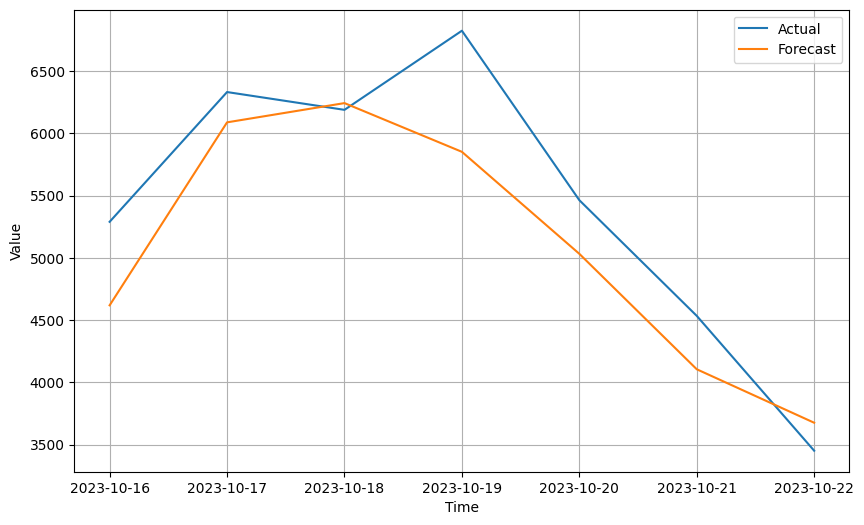

RMSE: 518.3636613915864


In [200]:
Start_date = '2023-10-16'
time_tmp=(plot_df.index.get_loc(Start_date))
time_stamp = time_tmp - G.SPLIT_TIME

# Create a date range starting from time_tmp. Adjust periods and freq as needed.
date_range = pd.date_range(start=Start_date, periods=7, freq='D')  # For example, 10 days

# Convert the date range to an array
date_array = date_range.to_pydatetime().tolist()

print(series_valid[time_stamp:time_stamp+7])
print(rnn_forecast[time_stamp:time_stamp+7])

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((series_valid[time_stamp:time_stamp+7] - rnn_forecast[time_stamp:time_stamp+7])**2))

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(date_array, (series_valid[time_stamp:time_stamp+7],rnn_forecast[time_stamp:time_stamp+7]), labels=["Actual", "Forecast"])

# Print the RMSE
print(f"RMSE: {rmse}")

**To pass this assignment your forecast should achieve a MSE of 6 or less and a MAE of 2 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save the model in the SavedModel format which will be used for grading and after doing so, submit your assigment for grading.


- This environment includes a dummy SavedModel directory which contains a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**

In [33]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/


**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging a combination of Tensorflow's layers such as Convolutional and LSTMs! This resulted in a forecast that surpasses all the ones you did previously.

**By finishing this assignment you have finished the specialization! Give yourself a pat on the back!!!**

<details>
  <summary><font size="2" color="darkgreen"><b>Please click here if you want to experiment with any of the non-graded code.</b></font></summary>
    <p><i><b>Important Note: Please only do this when you've already passed the assignment to avoid problems with the autograder.</b></i>
    <ol>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “Edit Metadata”</li>
        <li> Hit the “Edit Metadata” button next to the code cell which you want to lock/unlock</li>
        <li> Set the attribute value for “editable” to:
            <ul>
                <li> “true” if you want to unlock it </li>
                <li> “false” if you want to lock it </li>
            </ul>
        </li>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “None” </li>
    </ol>
    <p> Here's a short demo of how to do the steps above: 
        <br>
        <img src="https://drive.google.com/uc?export=view&id=14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1" align="center">
</details>